In [1]:
# import pandas and matplotlib
import pandas as pd
import matplotlib
#from matplotlib import style
#style.use('seaborn')
import numpy as np
from matplotlib import pyplot as plt

In [234]:
# import SQLalchemy create_engine, automap_base, session
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from sqlalchemy import distinct
from sqlalchemy import between, select

In [228]:
import datetime as dt

# Hawaii trip period
* Start date - 2017/07/08
* End data - 2017/07/15

In [4]:
# create engine for the hawaii.sqlite database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# use inpector to explore database and print table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [6]:
# use inpector to print column names and types for measurement
columns_m = inspector.get_columns('measurement')
for column in columns_m:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [60]:
# refelct database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.measurement
Stations = Base.classes.station

In [61]:
# start session to query the database
session = Session(engine)

In [304]:
# create variable to hold the query values for date and preciptation,
# last 12 months of data from the end of my trip 2017/07/15

# create variable to hold the date 12 months before the end of the trip
query_date = dt.date(2017, 7,15) - dt.timedelta(days=365)

# convert date to %Y-%m-%d format
end_date = dt.date(2017, 7, 15)
start_date = dt.date(2017, 7, 8)


# using the query_date created, filter the query session to get all the precipitation 
# for the 12 months
query_precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > query_date).\
    filter(Measurement.date < end_date).all()


datetime.date(2017, 7, 8)

In [63]:
# load the results from the variable created into Pandas dataframe 
measurement_df = pd.DataFrame(query_precipitation)
# set index on date
measurement_df.set_index('date', inplace=True)
# sort values by date
measurement_df.sort_values(by='date')
# rename prcp to Precipitation for readability
measurement = measurement_df.rename(columns={"prcp":"Precipitation"})
# clean data by dropping any na value
measurement_results = measurement.dropna()
# now that the dataframe is sorted by date, reset index to use dates as a list to plot
measurement_reset_index = measurement_results.reset_index()
measurement_reset_index.head()

,date,Precipitation
0,2016-07-16,0.03
1,2016-07-17,0.00
2,2016-07-18,1.25
3,2016-07-19,0.03
4,2016-07-20,0.00


In [64]:
#unpack results into lists to plot
dates = [date for date in measurement_reset_index['date']]
precipitations = [precipitation for precipitation in measurement_reset_index['Precipitation']]

## Precipitation Analysis

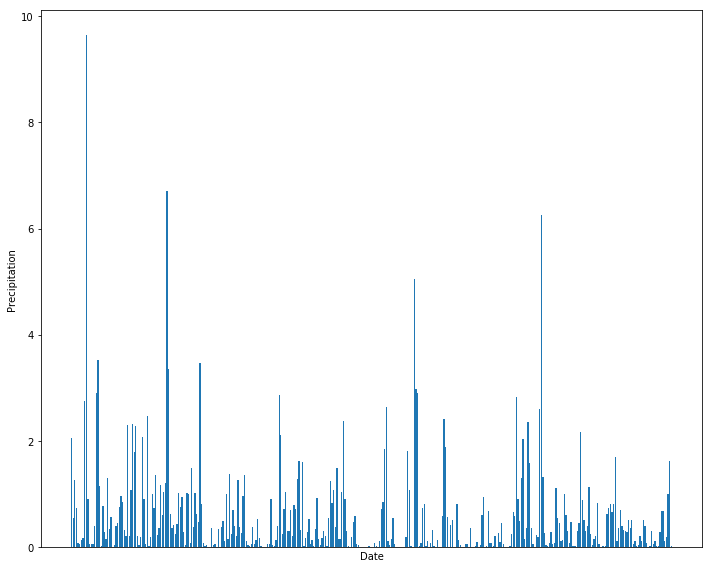

In [305]:
fig, ax =  plt.subplots(figsize=(10,8))
x_axis = np.arange(len(dates))
ax.bar(dates, precipitations)
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation")

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tight_layout()
plt.show()

In [66]:
measurement_reset_index.describe()

,Precipitation
count,2054.000000
mean,0.204245
std,0.567003
min,0.000000
25%,0.000000
50%,0.020000
75%,0.140000
max,9.640000


## Station Analysis

In [67]:
# use inpector to print column names and types for station
columns_s = inspector.get_columns('station')
for column in columns_s:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [68]:
# counts the number os stations available in this dataset
query_stations = session.query(func.distinct(Measurement.station)).count()
print(query_stations)

9


Most active stations in descending order

In [69]:
# finds the most active stations in descending order
active_stations = session.query((Measurement.station),\
    func.count(Measurement.station).label("Station_Activity")).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

#### Most active station's highest, lowest and average temperatures

In [70]:
# most active station (USC00519281)lowest temperature, highest temperature and average temp
most_active_station = session.query(func.min(Measurement.tobs).label('lowest_temp'),\
                      func.max(Measurement.tobs).label('highest_temp'),\
                      func.avg(Measurement.tobs).label('average_temp')).\
                      filter(Measurement.station == "USC00519281").all()

most_active_station

[(54.0, 85.0, 71.66378066378067)]

##### 12 months tobs filtered by station with highest number of observations 

In [71]:
# find station with the highest number of temperarute observations
# filtering by the period 12 months before the end of the trip

tobs_last_12months = session.query(Measurement.station,\
    func.count(Measurement.tobs).label("Highest_number_observations")).\
    filter(Measurement.date > query_date).\
    filter(Measurement.date < end_date).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()
tobs_last_12months

[('USC00513117', 365),
 ('USC00519281', 365),
 ('USC00519397', 363),
 ('USC00516128', 347),
 ('USC00519523', 340),
 ('USC00514830', 297),
 ('USC00517948', 195)]

 ###### top station tobs

In [72]:
# get all the data from the top station only
top_station_tobs = session.query(Measurement.tobs).\
    filter(Measurement.date > query_date).\
    filter(Measurement.date < end_date).\
    filter(Measurement.station == 'USC00513117').all()

In [73]:
# put the date into a Pandas dataframe to plot the histogram
top_station_tobs_df = pd.DataFrame(top_station_tobs)
top_station_tobs_df.head()

,tobs
0,75.0
1,76.0
2,76.0
3,75.0
4,78.0


#### Histogram

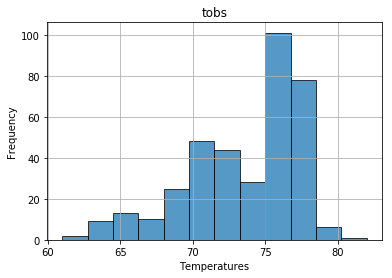

In [74]:
hist = top_station_tobs_df.hist(bins=12,edgecolor='black',alpha=0.75)

plt.xlabel('Temperatures')
plt.ylabel('Frequency')
plt.show()

## Temperature Analysis

In [295]:
# Highest temperature, lowest temperature and average temperature for the trip duration
def calc_temps(start_date, end_date):
    
    #start_date = session.query(func.strftime(Measurement.date) == "%Y-%m-%d")
    #end_date = session.query(func.strftime(Measurement.date) == "%Y-%m-%d")
    
    sel = [Measurement.date, func.min(Measurement.tobs).label('min_temp'),\
           func.max(Measurement.tobs).label('max_temp'),\
           func.avg(Measurement.tobs).label('avg_temp')]
    
    return session.query(*sel).\
           filter(Measurement.date >= start_date).\
           filter(Measurement.date <= end_date).\
           group_by(Measurement.date).all() 

print(calc_temps('2017-07-08', '2017-7-15'))

[('2017-07-08', 71.0, 81.0, 77.16666666666667), ('2017-07-09', 76.0, 82.0, 79.33333333333333), ('2017-07-10', 69.0, 82.0, 77.85714285714286), ('2017-07-11', 72.0, 81.0, 77.0), ('2017-07-12', 72.0, 82.0, 78.28571428571429), ('2017-07-13', 74.0, 81.0, 78.14285714285714), ('2017-07-14', 76.0, 81.0, 78.83333333333333), ('2017-07-15', 78.0, 82.0, 80.16666666666667), ('2017-07-16', 75.0, 82.0, 78.33333333333333), ('2017-07-17', 72.0, 82.0, 77.83333333333333), ('2017-07-18', 76.0, 83.0, 79.14285714285714), ('2017-07-19', 74.0, 81.0, 78.16666666666667), ('2017-07-20', 75.0, 80.0, 78.42857142857143), ('2017-07-21', 72.0, 81.0, 78.14285714285714), ('2017-07-22', 72.0, 81.0, 77.66666666666667), ('2017-07-23', 75.0, 82.0, 79.6), ('2017-07-24', 75.0, 79.0, 77.66666666666667), ('2017-07-25', 77.0, 81.0, 79.28571428571429), ('2017-07-26', 73.0, 84.0, 78.42857142857143), ('2017-07-27', 75.0, 80.0, 78.0), ('2017-07-28', 73.0, 81.0, 79.14285714285714), ('2017-07-29', 77.0, 83.0, 80.5), ('2017-07-30', 78

In [300]:
def calc_temps(start_date, end_date):
    #start_date = session.query(func.strftime(Measurement.date) == "%Y-%m-%d")
    #end_date = session.query(func.strftime(Measurement.date) == "%Y-%m-%d")
    
    return session.query(Measurement.date,func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
        group_by(Measurement.date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[('2012-02-28', 66.0, 70.375, 73.0), ('2012-02-29', 69.0, 72.11111111111111, 74.0), ('2012-03-01', 67.0, 71.11111111111111, 74.0), ('2012-03-02', 66.0, 69.25, 74.0), ('2012-03-03', 65.0, 69.71428571428571, 73.0), ('2012-03-04', 65.0, 68.85714285714286, 73.0), ('2012-03-05', 62.0, 65.0, 67.0)]


In [204]:
# previous year (2016) Highest temperature, lowest temperature and average temperature 


### Plot Trip Average Temperature

In [77]:
results = calc_temps('2017-07-08', '2017-07-15')
df = pd.DataFrame(results)
ptps = df['max_temp'] - df['min_temp']
y_axis = df['avg_temp']

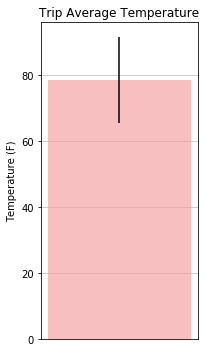

In [78]:
fig, ax = plt.subplots(figsize=(3, 5))

ax.bar(np.arange(0, len(y_axis)) ,y_axis, yerr=ptps, color='lightcoral', alpha=0.5)

ax.set_title('Trip Average Temperature')
ax.set_ylabel('Temperature (F)')

ax.yaxis.grid(alpha=0.75)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tight_layout()
plt.show()
fig.savefig("trip_avg_temp.png")

Other Recommended Analysis (Optional)


The following are optional challenge queries. These are highly recommended to attempt, but not required for the homework.

Calculate the rainfall per weather station using the previous year's matching dates.



### Rainfall per Weather Station

In [194]:
def rainfall_station(start_date, end_date):
    start_date = session.query(func.strftime("%Y-%m-%d", Measurement.date))
    end_date = session.query(func.strftime("%Y-%m-%d", Measurement.date))
    
    sel = [Stations.name, Stations.latitude, Stations.longitude, Stations.elevation,\
          func.avg(Measurement.prcp), Measurement.date]  
    
    return session.query(*sel).filter(Measurement.station == Stations.station).\
                      filter(Measurement.date >= start_date).\
                      filter(Measurement.date <= end_date).\
                      group_by(Measurement.station).\
                      order_by(func.avg(Measurement.prcp).desc()).all()
rainfall_station('2017-7-08', '2017-07-15')
 

[('KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.28, '2010-01-01'),
 ('UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.21, '2010-01-01'),
 ('WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.15,
  '2010-01-01'),
 ('WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.15,
  '2010-01-01'),
 ('MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.14,
  '2010-01-01'),
 ('WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.08, '2010-01-01'),
 ('HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.05,
  '2010-01-01')]

Calculate the daily normals. Normals are the averages for the min, avg, and max temperatures.


You are provided with a function called daily_normals that will calculate the daily normals for a specific date. This date string will be in the format %m-%d. Be sure to use all historic tobs that match that date string.


Create a list of dates for your trip in the format %m-%d. Use the daily_normals function to calculate the normals for each date string and append the results to a list.


Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.


Use Pandas to plot an area plot (stacked=False) for the daily normals.


In [123]:
# Create a query that will calculate the daily normals 

def daily_normals(date):
      
    date = session.query(func.strftime("%m-%d", Measurement.date))
    
    sel = [Measurement.date,func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).\
                               group_by(Measurement.date).all()
    
daily_normals("1-01")

[('2010-01-01', 65.0, 69.71428571428571, 75.0),
 ('2011-01-01', 69.0, 72.14285714285714, 77.0),
 ('2012-01-01', 63.0, 68.42857142857143, 71.0),
 ('2013-01-01', 69.0, 70.5, 72.0),
 ('2014-01-01', 65.0, 68.66666666666667, 75.0),
 ('2015-01-01', 63.0, 66.28571428571429, 71.0),
 ('2016-01-01', 62.0, 68.16666666666667, 74.0),
 ('2017-01-01', 62.0, 69.33333333333333, 74.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
# Set the start and end date of the trip
start_date = "2017-07-08"
end_date - "2017-07-15"
# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`